In [1]:
from os import listdir
from os.path import isfile, join
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math as math
from scipy.optimize import minimize
import scipy.stats as ss
from scipy.signal import find_peaks 
from matplotlib import rc
import codecs

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#en figur der fylder en kolonne har bredde 5,8, f.eks: fig, ax= plt.subplots(figsize=(5.8,4))
#en figur der fylder to kolonner har dobbeltbredde??

In [2]:
#til at slå op i masses.dat
data = np.transpose(np.loadtxt("masses.txt"))

N=data[0]
Z=data[1]
A=data[2]
massExcess=data[3]
bEPrNkl=data[4]

mp = 938.272
me = 0.510998
mn = 939.565

def me2(a, z):
    a_indices = np.where(A == a)
    z_indices = np.where(Z == z)
    a = lambda: print('Could not find mass excess for given numbers')
    for i in range(len(a_indices[0])):
        if np.any(z_indices[0] == a_indices[0][i]):
            me = massExcess[a_indices[0][i]]/1000
            a = lambda: me
    return a()

def m2(a,z): 
    return a*931.49410242+me2(a,z)

In [3]:
def factor(m1, m2, t): #t er lab scatteringvinkel i radianer.
    mr = m1*m2/(m1+m2)
    
    def toSolve(x):
        return 1/np.tan(x)+m1/m2*1/np.sin(x)-1/np.tan(t)
    
    vinkelCOM = fsolve(toSolve,t) #brug t som startgæt til fsolve
    
    return mr**2*(1/m1**2+1/m2**2+2/(m1*m2)*np.cos(vinkelCOM))

In [4]:
#beregn Tb ud fra 11.5 i Krane
def Tb(t,Ta):
    mY=m2(27,13)
    ma=mp
    mb=mp
    return np.power((np.sqrt(ma*mb*Ta)*np.cos(t)+np.sqrt((ma*mb*Ta*np.cos(t)**2+(mY+mb)*(mY-ma)*Ta)))/(mY+mb),2)

In [5]:
vinkler = np.linspace(0,180,1000)
factors = []

mypath = "peaks"
peaktxts = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
57/2000

0.0285

In [8]:
thetas = []
peakpos = []
energies = []
pointsToFit = []
anglesToFit = []
errorsToFit = []
fitindex = 0

for i in range(len(peaktxts)):
    energyGV = int(''.join(filter(str.isdigit, peaktxts[i])))
    energies.append(energyGV)
    adress = "peaks/" + peaktxts[i]
    data = np.transpose(np.loadtxt(adress,skiprows=1))
    thetas.append(data[0])
    peakpos.append(data[1])
    fittingGV = []
    fittingTheta = []
    fittingError = []
    distance = 0.015*energyGV
    for k in range(len(data[1])):
        theta = data[0][k]
        energyScatter = data[1][k]
        energyError = data[2][k]
        if(np.abs(energyScatter - Tb(theta/360*2*np.pi,energyGV)) <= distance):
            fittingGV.append(energyScatter)
            fittingTheta.append(theta)
            fittingError.append(energyError)
    pointsToFit.append(fittingGV)
    anglesToFit.append(fittingTheta)
    errorsToFit.append(fittingError)

(1001.0, 2001.0)

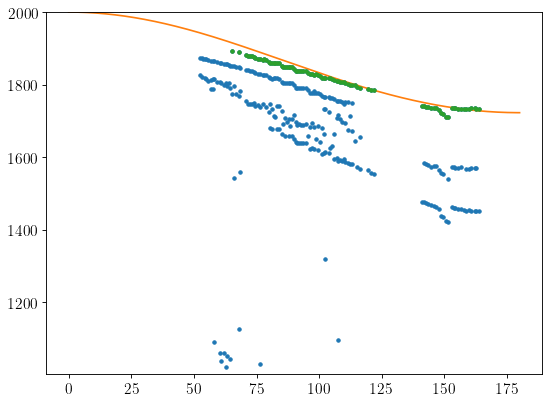

In [9]:
i = 2
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(thetas[i],peakpos[i], '.', alpha=1)
#plt.plot(vinkler,2000*np.array(factors))
plt.plot(vinkler,Tb(vinkler/360*2*np.pi,energies[i]))
plt.plot(anglesToFit[i],pointsToFit[i], '.')
plt.ylim(energies[i]-1000,energies[i])

In [14]:
gvE = []
mE = []
mEerr = []

for i in range(len(energies)):
    popt, pcov = curve_fit(Tb,anglesToFit[i],pointsToFit[i],energies[i])#sigma=errorsToFit[i],absolute_sigma=True)
    gvE.append(energies[i]*1.17)
    mE.append(popt[0])
    mEerr.append(np.sqrt(pcov[0][0]))

In [15]:
def l(x,a):
    return a*x

popt,pcov = curve_fit(l,gvE,mE,sigma=mEerr,absolute_sigma = False)

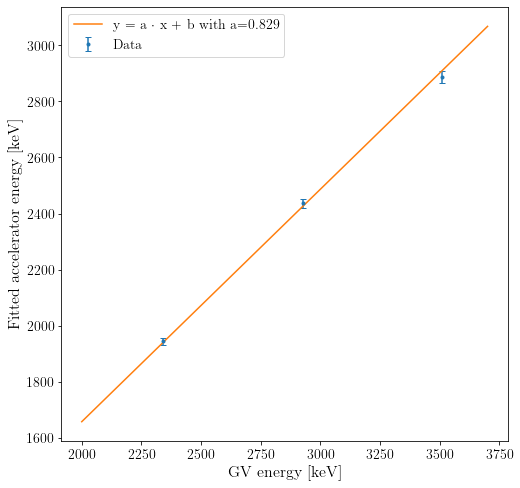

In [16]:
gvElinspace = np.linspace(2000,3700,1000)
fig, ax = plt.subplots(figsize = [8,8])
ax.errorbar(gvE,mE,yerr=mEerr,fmt='.',capsize=3, label = 'Data')
ax.plot(gvElinspace,l(gvElinspace,*popt), label = r'y = a $\cdot$ x + b with a=' + str(np.round(popt[0],4)))# + ", b=" + str(np.round(popt[1],4)))
ax.set_xlabel('GV energy [keV]')
ax.set_ylabel('Fitted accelerator energy [keV]')
ax.legend()

In [13]:
1/popt[0]

1.2101089667180351